In [18]:
import os
import json
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models    import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
with open('/Users/katrindar/MIPT/Masters/kaggle/kaggle.json', "r") as f:
    kaggle_token = json.load(f)
    
# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [20]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [21]:
# import zipfile

# with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [22]:
train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'

model_path = 'test_model.keras'

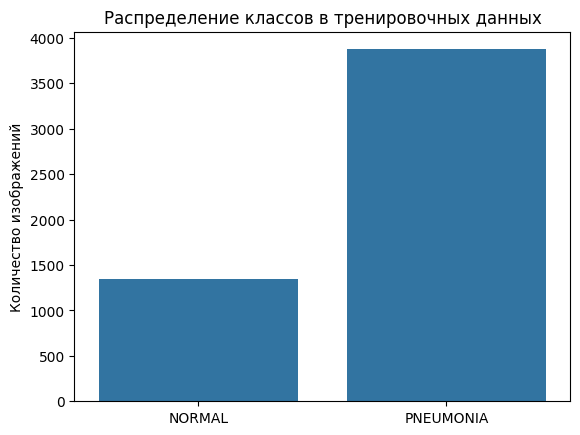

In [23]:
train_normal = len(os.listdir(f'{train_dir}NORMAL'))
train_pneumonia = len(os.listdir(f'{train_dir}PNEUMONIA'))

sns.barplot(x=['NORMAL', 'PNEUMONIA'], y=[train_normal, train_pneumonia])
plt.title('Распределение классов в тренировочных данных')
plt.ylabel('Количество изображений')
plt.show()

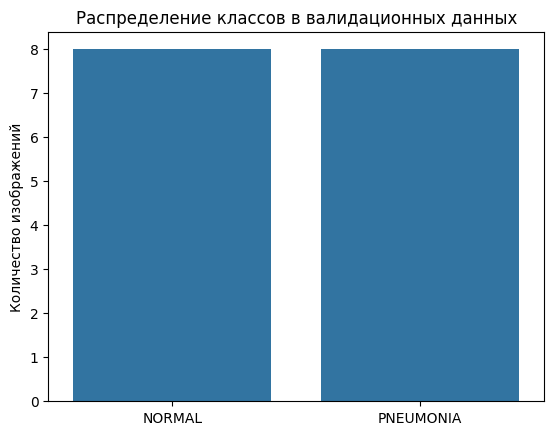

In [24]:
val_normal = len(os.listdir(f'{val_dir}NORMAL'))
val_pneumonia = len(os.listdir(f'{val_dir}PNEUMONIA'))

sns.barplot(x=['NORMAL', 'PNEUMONIA'], y=[val_normal, val_pneumonia])
plt.title('Распределение классов в валидационных данных')
plt.ylabel('Количество изображений')
plt.show()

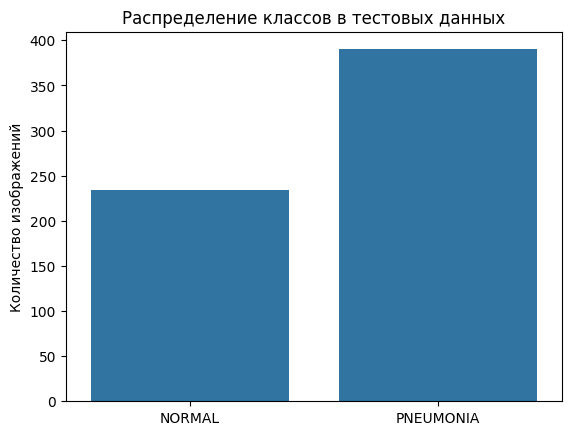

In [25]:
test_normal = len(os.listdir(f'{test_dir}NORMAL'))
test_pneumonia = len(os.listdir(f'{test_dir}PNEUMONIA'))

sns.barplot(x=['NORMAL', 'PNEUMONIA'], y=[test_normal, test_pneumonia])
plt.title('Распределение классов в тестовых данных')
plt.ylabel('Количество изображений')
plt.show()

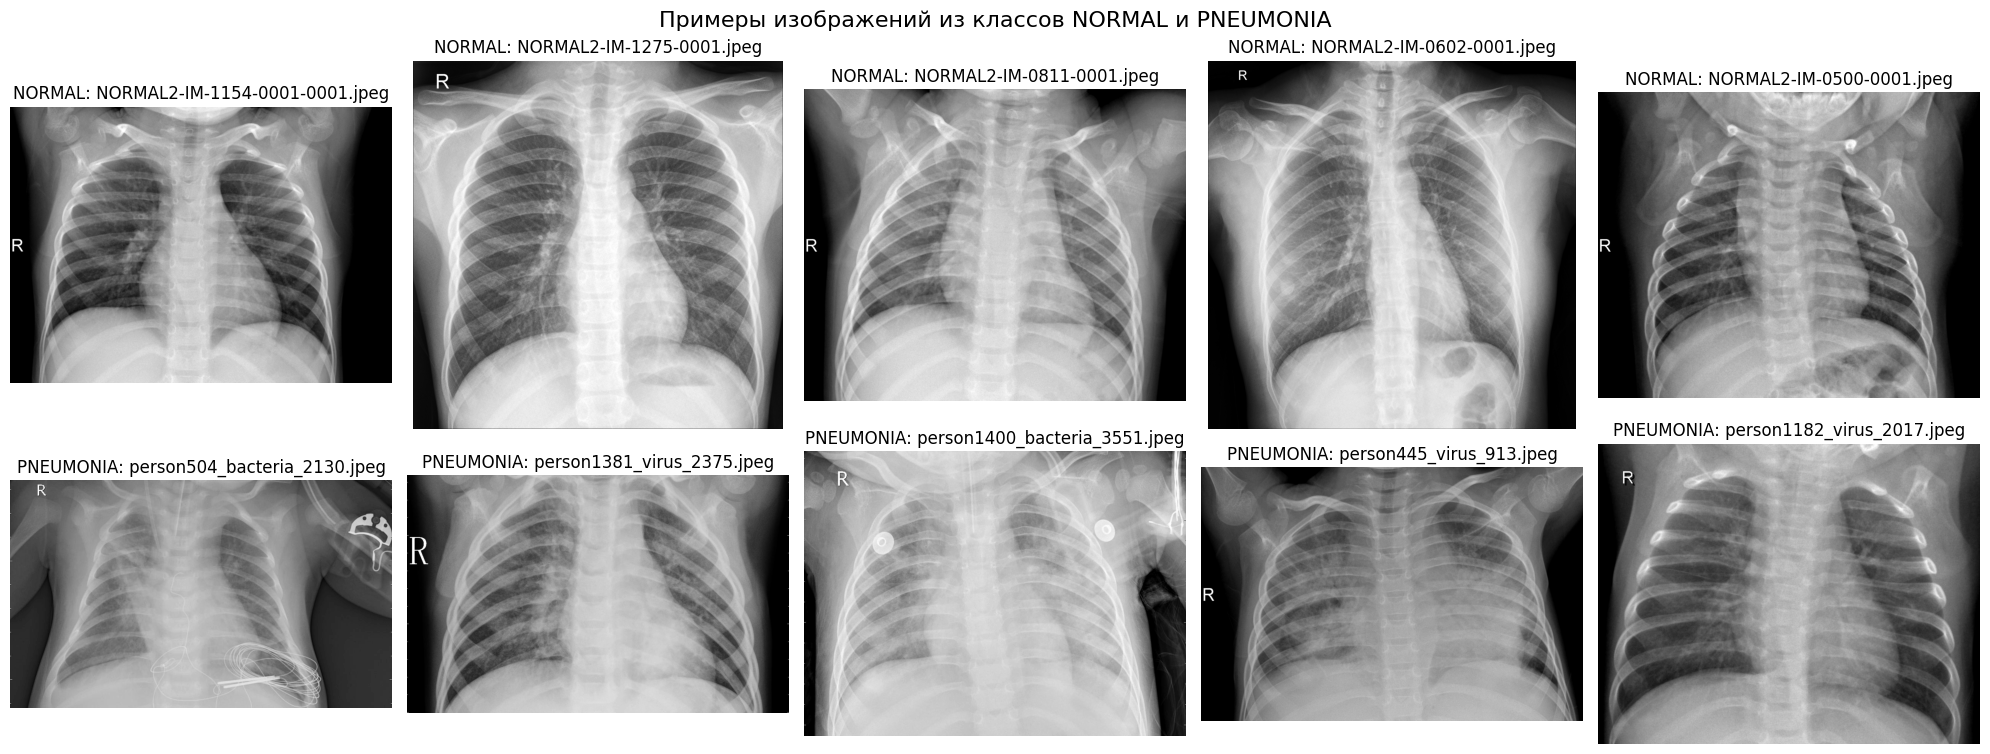

In [26]:
# Функция для загрузки случайных изображений из указанной папки
def load_random_images_from_folder(folder, num_images=5):
    image_files = os.listdir(folder)
    random_files = random.sample(image_files, num_images)
    images = [Image.open(os.path.join(folder, file)) for file in random_files]
    return images, random_files

# Загружаем несколько случайных изображений из NORMAL и PNEUMONIA
normal_images, normal_files = load_random_images_from_folder(train_dir + 'NORMAL')
pneumonia_images, pneumonia_files = load_random_images_from_folder(train_dir + 'PNEUMONIA')

# Показываем изображения
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Примеры изображений из классов NORMAL и PNEUMONIA', fontsize=16)

for i, img in enumerate(normal_images):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'NORMAL: {normal_files[i]}')
    axes[0, i].axis('off')

for i, img in enumerate(pneumonia_images):
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'PNEUMONIA: {pneumonia_files[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [27]:
sizes = []
path = 'data/train/NORMAL'
for file in os.listdir(path):
    with Image.open(os.path.join(path, file)) as img:
        sizes.append(img.size)

sizes = np.array(sizes)
unique_sizes, counts = np.unique(sizes, axis=0, return_counts=True)
print("Размеры и частота:", list(zip(unique_sizes, counts)))

Размеры и частота: [(array([912, 672]), 1), (array([976, 800]), 1), (array([992, 816]), 1), (array([994, 758]), 1), (array([1014,  846]), 1), (array([1040,  747]), 1), (array([1056,  792]), 1), (array([1064,  842]), 1), (array([1088,  824]), 1), (array([1088,  968]), 1), (array([1090,  793]), 1), (array([1098,  955]), 1), (array([1110,  944]), 1), (array([1114,  815]), 1), (array([1114,  832]), 1), (array([1114,  843]), 1), (array([1114,  850]), 1), (array([1118,  932]), 1), (array([1120,  904]), 1), (array([1126, 1012]), 1), (array([1128,  966]), 1), (array([1130,  831]), 1), (array([1140,  846]), 1), (array([1144,  966]), 1), (array([1148,  908]), 1), (array([1156,  804]), 1), (array([1156, 1237]), 1), (array([1160,  897]), 1), (array([1160,  904]), 1), (array([1164, 1021]), 1), (array([1164, 1086]), 1), (array([1168,  960]), 1), (array([1172,  967]), 1), (array([1172,  986]), 1), (array([1180,  885]), 1), (array([1184,  984]), 1), (array([1186,  769]), 1), (array([1186,  940]), 1), 

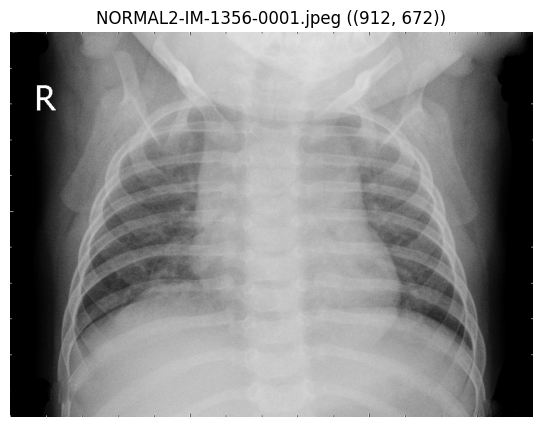

In [28]:
path = 'data/train/NORMAL'
target_size = (912, 672)

selected_images = []
for img_name in os.listdir(path):
    img = Image.open(os.path.join(path, img_name))
    if img.size == target_size:
        selected_images.append(img_name)

plt.figure(figsize=(15,5))
for i, img_name in enumerate(selected_images[:5]):
    img = Image.open(os.path.join(path, img_name))
    plt.subplot(1, len(selected_images[:5]), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{img_name} ({img.size})')
    plt.axis('off')
plt.show()

In [29]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def show_blurred_images(path, threshold=50, num_images=5):
    blurred_images = []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if variance_of_laplacian(img) < threshold:
            blurred_images.append(img_name)

    selected_images = random.sample(blurred_images, min(num_images, len(blurred_images)))

    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(selected_images):
        img = Image.open(os.path.join(path, img_name))
        plt.subplot(1, len(selected_images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Blur: {img_name}')
        plt.axis('off')
    plt.show()


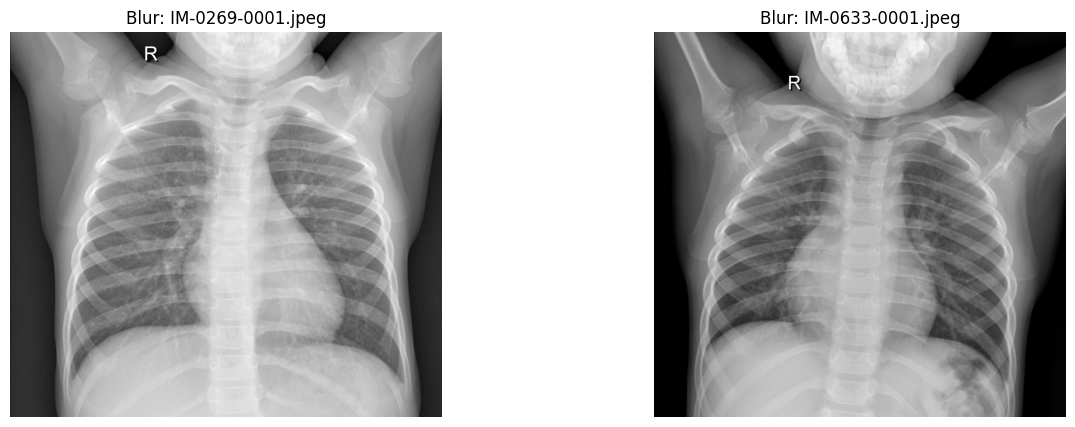

In [30]:
show_blurred_images('data/train/NORMAL')

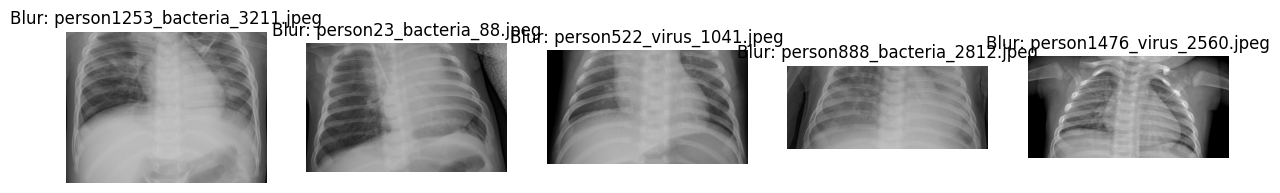

In [31]:
show_blurred_images('data/train/PNEUMONIA')

In [32]:
# Генератор для тренировочных данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1,  # нормализация [-1; 1]
    rotation_range=10,     # поворот ±10°
    width_shift_range=0.1, # горизонтальное смещение ±10%
    height_shift_range=0.1, # вертикальное смещение ±10%
    horizontal_flip=False,  # горизонтальное отражение
    zoom_range=0.1,        # масштабирование ±10%
    shear_range=0.1,       # сдвиг по оси сдвига
    brightness_range=[0.8, 1.2], # изменение яркости
    fill_mode='nearest'    # заполнение новых пикселей ближайшими значениями
)

# Генератор для валидации и теста (только ресайз и нормализация)
test_val_datagen = ImageDataGenerator(rescale=1./127.5 - 1)

# Генератор данных тренировочного набора
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Генератор данных валидационного набора
valid_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Генератор данных тестового набора
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [33]:
# Генератор для тренировки с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1,  # нормализация [-1; 1]
    rotation_range=10,     # поворот ±10°
    width_shift_range=0.1, # горизонтальное смещение ±10%
    height_shift_range=0.1, # вертикальное смещение ±10%
    horizontal_flip=False,  # горизонтальное отражение
    zoom_range=0.1,        # масштабирование ±10%
    shear_range=0.1,       # сдвиг по оси сдвига
    brightness_range=[0.8, 1.2], # изменение яркости
    validation_split=0.15  # выделение 15% для валидации из train
)

# Генератор для валидации и теста (только ресайз и нормализация)
test_val_datagen = ImageDataGenerator(rescale=1./127.5 - 1)

# Тренировочный генератор (только train)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',  # Используем только часть для тренировки
)

# Генератор валидации (из train)
# Используем subset='validation' для получения валидационного набора из train

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset='validation' # Используем только часть для валидации из train
)

# Генератор данных тестового набора
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
# sweep_config = {
# }

# sweep_id = wandb.sweep(sweep_config, project="chest_x_ray")

In [35]:
# Создание простой CNN (менее 1 млн параметров)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# Обучение модели
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 91s 646ms/step - accuracy: 0.6778 - loss: 1.6858 - val_accuracy: 0.7481 - val_loss: 0.4490
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 102s 730ms/step - accuracy: 0.7719 - loss: 0.4474 - val_accuracy: 0.7839 - val_loss: 0.4078
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 95s 683ms/step - accuracy: 0.8311 - loss: 0.3731 - val_accuracy: 0.7749 - val_loss: 0.4029
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 722ms/step - accuracy: 0.8387 - loss: 0.3469 - val_accuracy: 0.8107 - val_loss: 0.3636
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 95s 685ms/step - accuracy: 0.8622 - loss: 0.3094 - val_accuracy: 0.8069 - val_loss: 0.3996
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 97s 696ms/step - accuracy: 0.8533 - loss: 0.3217 - val_accuracy: 0.8376 - val_loss: 0.3130
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 103s 743ms/step - accuracy: 0.8764 - loss: 0.2791 - val_accuracy: 0.8261 - val_loss: 0.3467
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 728ms/step - accuracy: 0.8809 - los

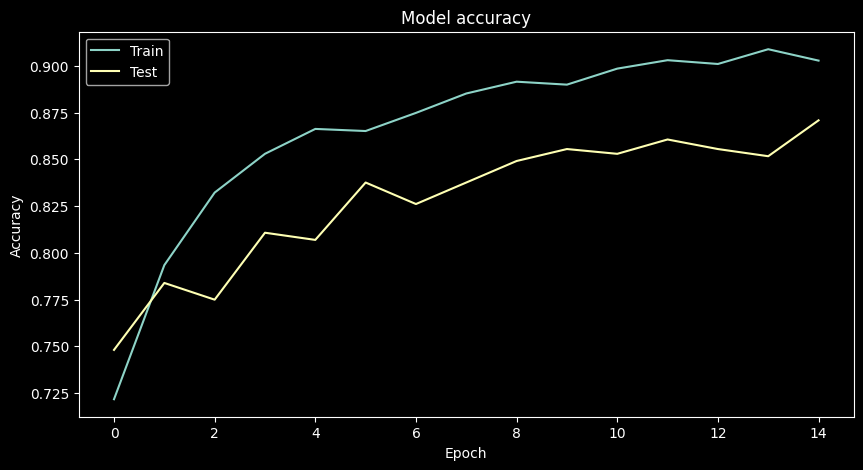

In [36]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

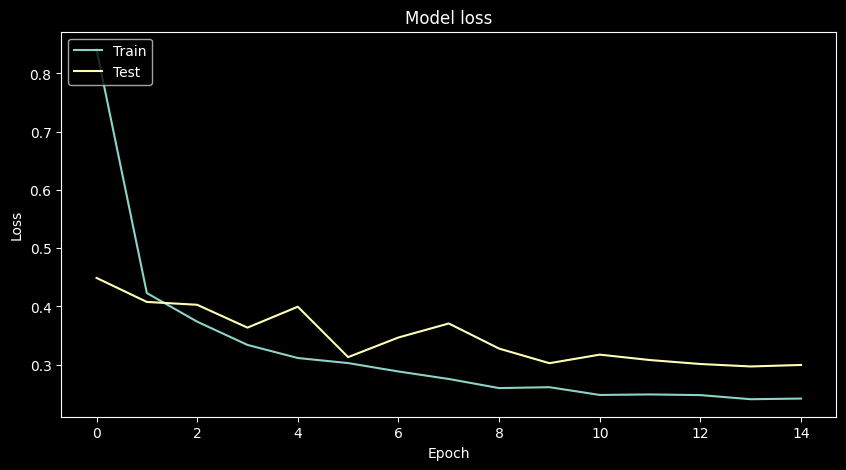

In [37]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step
              precision    recall  f1-score   support

      NORMAL       0.82      0.54      0.65       234
   PNEUMONIA       0.77      0.93      0.84       390

    accuracy                           0.78       624
   macro avg       0.80      0.73      0.75       624
weighted avg       0.79      0.78      0.77       624

ROC-AUC: 0.880


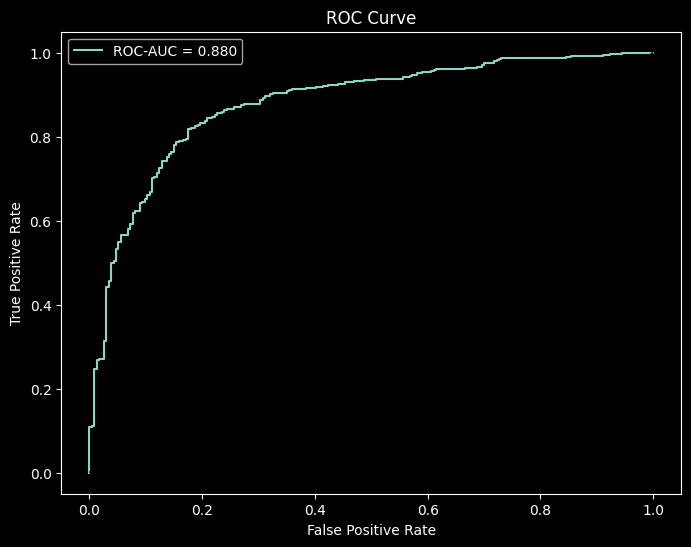

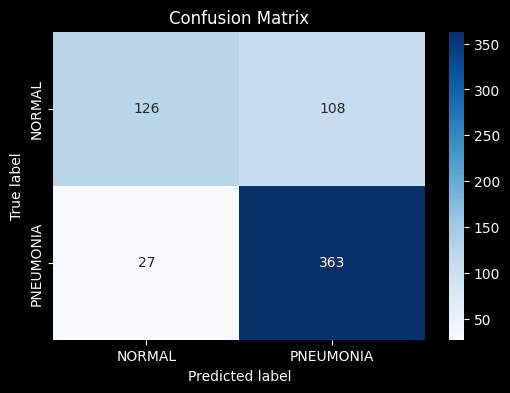

In [38]:
# Предсказание на тестовых данных
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Ключевые метрики
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.3f}")

# График ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Матрица ошибок
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
SEED = 42
tf.random.set_seed(SEED)

# 1. Base feature extractor (pre-trained on ImageNet)
base = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False            # freeze for warm-up

# 2. Task-specific head
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.30, seed=SEED)(x)   # helps regularise on small data
out = Dense(1, activation="sigmoid")(x)

tl_model = Model(inputs=base.input, outputs=out)
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="roc_auc")
    ]
)

# 3. Warm-up training (frozen backbone)
warmup_epochs = 5
history_warm = tl_model.fit(
    train_generator,
    epochs=warmup_epochs,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(patience=2, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.3, patience=1, verbose=1)
    ]
)

# 4. Fine-tune: unfreeze last N layers of MobileNetV2
for layer in base.layers[-50:]:
    layer.trainable = True

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),   # lower LR for fine-tuning
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="roc_auc")
    ]
)

finetune_epochs = 8
history_ft = tl_model.fit(
    train_generator,
    initial_epoch=warmup_epochs,
    epochs=warmup_epochs + finetune_epochs,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.3, patience=1, verbose=1)
    ]
)


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 566ms/step - accuracy: 0.7935 - loss: 0.4406 - precision: 0.8218 - recall: 0.9238 - roc_auc: 0.8011 - val_accuracy: 0.8670 - val_loss: 0.3052 - val_precision: 0.8878 - val_recall: 0.9398 - val_roc_auc: 0.9262 - learning_rate: 0.0010
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 78s 560ms/step - accuracy: 0.8968 - loss: 0.2521 - precision: 0.9212 - recall: 0.9410 - roc_auc: 0.9496 - val_accuracy: 0.8824 - val_loss: 0.2798 - val_precision: 0.9358 - val_recall: 0.9036 - val_roc_auc: 0.9451 - learning_rate: 0.0010
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 598ms/step - accuracy: 0.9201 - loss: 0.1986 - precision: 0.9435 - recall: 0.9506 - roc_auc: 0.9695 - val_accuracy: 0.9003 - val_loss: 0.2457 - val_precision: 0.9359 - val_recall: 0.9294 - val_roc_auc: 0.9500 - learning_rate: 0.0010
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 598ms/step - accuracy: 0.9312 - loss: 0.1866 - precision: 0.9493 - recall: 0.9589 - roc_auc: 0.9720 - val_accuracy: 0.9041 - val_

In [40]:
# 5. Evaluate on held-out test set
test_metrics = tl_model.evaluate(test_generator, verbose=0)
metric_names = tl_model.metrics_names
print("\nTest-set metrics:")
for name, value in zip(metric_names, test_metrics):
    print(f"{name:>10s}: {value:.4f}")


Test-set metrics:
      loss: 0.8766
compile_metrics: 0.7420


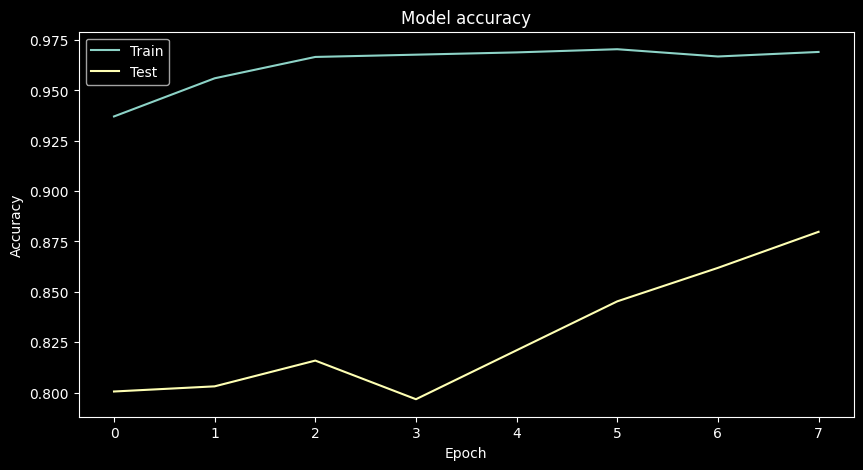

In [41]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

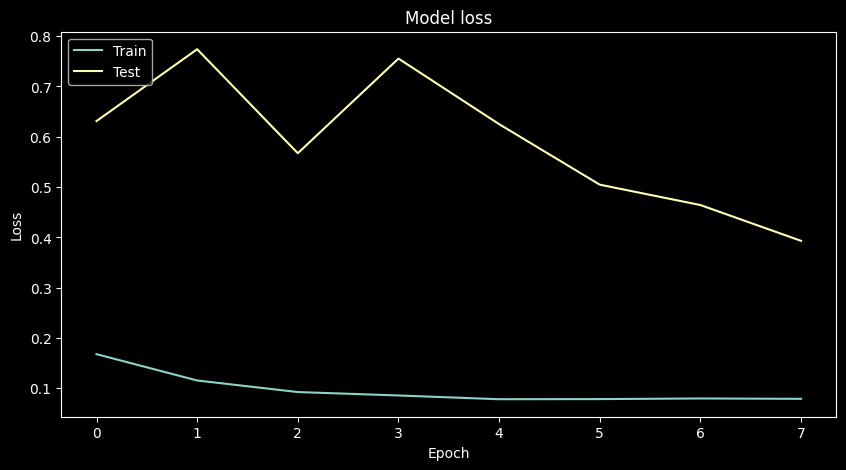

In [42]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.32      0.48       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624

ROC-AUC: 0.944


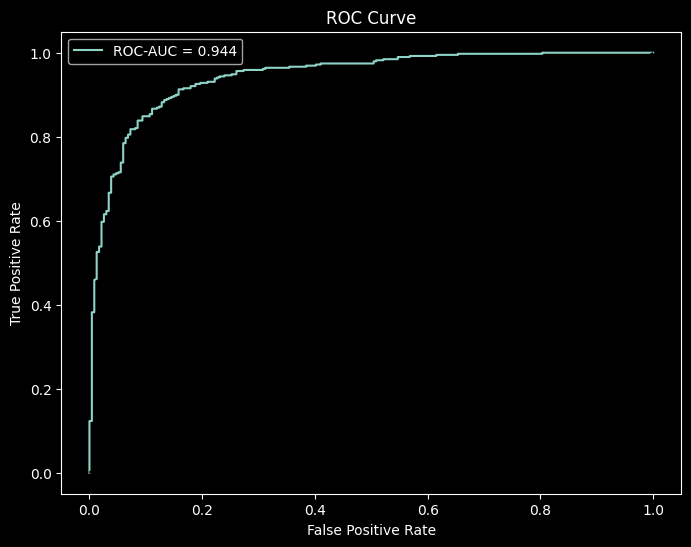

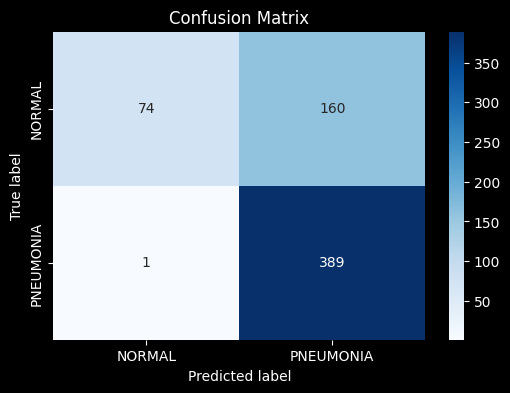

In [43]:
# Предсказание на тестовых данных
y_true = test_generator.classes
y_pred_prob = tl_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Ключевые метрики 
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.3f}")

# График ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Матрица ошибок
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()